# Image Classification with Transfer Learning and Multi-Head Self-Attention

In this notebook, we:
- Explain what multi-head attention is
- Understand its math and implementation
- Build a CNN+Transformer hybrid model


## 🤯 What is Multi-Head Attention?
Multi-head attention extends self-attention by using multiple attention heads. Each head can learn different aspects of the data.

This allows the model to capture various relationships in different subspaces of the input representation.

## 💡 Why Use Multi-Head Attention?
Instead of learning a single attention function, multi-head attention projects the input into multiple lower-dimensional subspaces, learns attention separately, and then concatenates the outputs.

This:
- Improves representation power
- Helps capture richer feature dependencies

## 🧮 Multi-Head Attention Math
Given input $X \in \mathbb{R}^{T \times D}$:
1. Project to queries, keys, values for each head:
   - $Q_i = XW^Q_i$, $K_i = XW^K_i$, $V_i = XW^V_i$ where $i=1,...,h$
2. Compute attention per head:
   - $A_i = \text{softmax}(\frac{Q_i K_i^T}{\sqrt{d}}) V_i$
3. Concatenate and project:
   - $\text{Concat}(A_1, ..., A_h) W^O$

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.proj_dim = embed_dim // num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        # [B, T, D] -> [B, h, T, d]
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.proj_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        Q = self.query_dense(inputs)
        K = self.key_dense(inputs)
        V = self.value_dense(inputs)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(self.proj_dim, tf.float32))
        weights = tf.nn.softmax(score / scale, axis=-1)

        attention = tf.matmul(weights, V)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))

        return self.combine_heads(concat_attention)

## 🏗️ Build the Model with MobileNetV2 + Multi-Head Self-Attention

In [2]:
def build_model_with_mhsa(num_classes=2):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = layers.Input(shape=(224, 224, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x)                             # [B, 7, 7, 1280]
    x = layers.Reshape((49, 1280))(x)             # [B, 49, 1280]

    x = MultiHeadSelfAttention(embed_dim=1280, num_heads=8)(x)  # [B, 49, 1280]
    x = layers.GlobalAveragePooling1D()(x)        # [B, 1280]
    x = layers.Dense(256, activation='relu')(x)   # [B, 256]
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

model = build_model_with_mhsa(num_classes=2)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 49, 1280)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_self_attention       │ (None, None, 1280)     │     6,558,720 │
│ (MultiHeadSelfAttention)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,145,154 (34.89 MB)

 Trainable params: 6,887,170 (26.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

# Download the dataset from Microsoft (hosted by TensorFlow)
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=url, extract=True)

# Get dataset path
dataset_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'validation')

# Load data into TensorFlow datasets
IMG_SIZE = 224
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=(IMG_SIZE, IMG_SIZE))

val_dataset = image_dataset_from_directory(val_dir,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           image_size=(IMG_SIZE, IMG_SIZE))

# Prefetch for performance
train_dataset = train_dataset.prefetch(buffer_size=32)
val_dataset = val_dataset.prefetch(buffer_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [9]:
# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.9119 - loss: 0.3451 - val_accuracy: 0.9780 - val_loss: 0.0870
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.9804 - loss: 0.0825 - val_accuracy: 0.9780 - val_loss: 0.1767
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9611 - loss: 1.2189 - val_accuracy: 0.9800 - val_loss: 0.9480
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9807 - loss: 0.8468 - val_accuracy: 0.9800 - val_loss: 0.3604
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9908 - loss: 0.0964 - val_accuracy: 0.9840 - val_loss: 0.1808


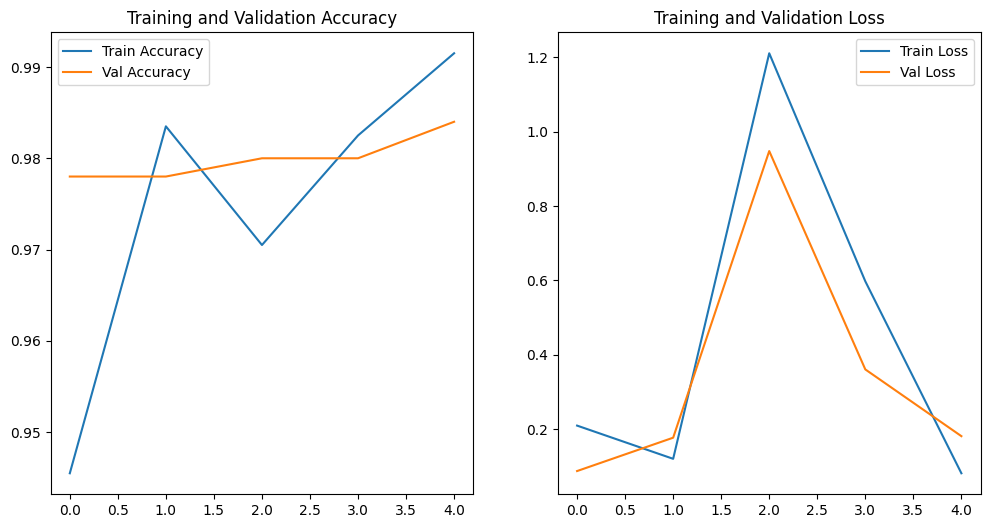

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()